In [1]:
import numpy as np
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from mol_tools.tools import QaAgent, SmilesFilter, SMILESEnergyPredictionTool, RetriverTool
from langchain_openai import ChatOpenAI
from dotenv import find_dotenv, load_dotenv
import logging

In [2]:
# set up
logging.basicConfig(level=logging.INFO)
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
llm = ChatOpenAI(model_name="gpt-3.5-turbo") 
embeddings_provider = OpenAIEmbeddings(model="text-embedding-3-small")
# loader = WebBaseLoader("https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8264982/")
loader = PyPDFLoader("storage/13045_2021_Article_1121.pdf")
docs = loader.load() 
text = " ".join([page.page_content for page in docs])

# Part 1: Custom Retriever Tool Development

#### Ask questions about the paper

In [3]:
questions = [
    "What disease are they discussing in the paper?",
    "Summarize the main takeaways from the paper.",
    "Can you list the protein targets they highlight in the paper?",
    "Can you list the small molecule drugs they highlight in the paper?",
]

In [14]:
retriever_tool = RetriverTool(
    docs, embeddings_provider, vector_path="storage/PMC8264982.faiss"
)
qa = QaAgent(retriever_tool, llm)
# disable logging
logging.disable(logging.CRITICAL)
for q in questions:
    print("Question:", q, "\n Answer:", qa.answer(q))
#enable logging
logging.disable(logging.NOTSET)

Question: What disease are they discussing in the paper? 
 Answer: The paper discusses targeted therapy in advanced non-small cell lung cancer (NSCLC).
Question: Summarize the main takeaways from the paper. 
 Answer: The paper discusses the importance of predictive biomarkers in advanced non-small cell lung cancer (NSCLC) and highlights the various actionable mutations such as EGFR, ALK, ROS1, BRAF, MET, RET, and NTRK. It provides information on FDA-approved targeted therapies for these mutations, focusing on EGFR inhibitors for EGFR-mutant NSCLC. The paper also addresses resistance mechanisms to EGFR TKIs and ongoing clinical trials exploring treatment options for patients who have progressed after osimertinib therapy. Overall, the paper emphasizes the significance of personalized medicine and targeted therapies in the management of advanced NSCLC.
Question: Can you list the protein targets they highlight in the paper? 
 Answer: The protein targets highlighted in the paper include NFE

#### Search for SMILES strings

In [6]:
%%capture
smiles_filter = SmilesFilter()
text = " ".join([page.page_content for page in docs])
smiles_tokens = smiles_filter.filter(text)

INFO:root:Processing 13598 tokens


In [7]:
print("SMILES tokens:", smiles_tokens)

SMILES tokens: ['I/II', 'I/II', 'I/II', 'II', 'III', 'III', 'I/II', 'II', 'II', 'IIB', 'CI', 'II', 'I/II', 'I/II', 'CNS', 'II', 'PPP', 'CI', 'CI', 'CI', 'CI', 'I/II', '\nCNS', 'I/II', 'CNS', 'I/II', '\nI', 'I/II', 'III', 'I/II', '\nOS', 'I/II', 'II', 'CI', 'I/II', 'I/II', 'II', 'II', 'CI', 'I/II', '\nI/II', 'III', 'I/II', 'I/II', 'II', 'IB', 'I/II', 'I/II', '\nI/II', 'CI', 'CI', 'I-II', 'CI', 'II', 'I/II', 'II', 'CI', 'I/II', 'CNS', 'II', 'I/II', 'OS', 'III', 'II', 'I/II', 'III', 'I/II', 'I/II', 'I/II', 'I/II', 'I/II', 'II', 'I/II', 'I/II', 'I/II', 'I/II', 'I/II', '\nI/II', '\nNCCN', '\nII', 'CI', 'CI', 'CI', 'II', 'I/II', 'I/II', 'I/II', 'I/II', 'II', 'CNS', 'II', 'II', 'III', 'I/II', 'III', '\nI/II', 'I/II', 'II', 'I/II', 'II', 'II']


# Part 2: Predictive Machine Learning Model Tooling Implementation

#### Trian a model (Regression)

In [9]:
from mol_tools.trainer import train
from sklearn.metrics import mean_absolute_error
from mol_tools.data_utils import get_freesolv_data
X_train, X_test, y_train, y_test = get_freesolv_data()
mlp_model = train(X_train, y_train, model= "mlp_regression")
tree_regressor = train(X_train, y_train, model="tree_regression")
ensamble_regressor = train(X_train, y_train, model="AutoSklearnRegressor")
models = {"mlp": mlp_model, "tree": tree_regressor, "ensamble": ensamble_regressor}

INFO:root:Data loaded with 481 samples
INFO:root:Training <class 'mol_tools.models.SkLearnMLPRegression'> model


/home/v-oostapenko/miniconda3/envs/vllns/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
INFO:root:Model saved at storage/_mlp_regression.pkl
INFO:root:Data loaded with 481 samples
INFO:root:Training <class 'mol_tools.models.SkLearnTreeRegression'> model
INFO:root:Model saved at storage/_tree_regression.pkl
INFO:root:Data loaded with 481 samples
INFO:root:Training <class 'mol_tools.models.AutoSklearnRegressorModel'> model


Text(0, 0.5, 'MAE')

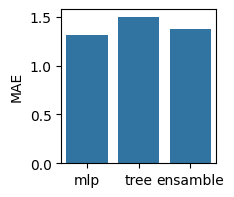

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
results = {}
for model in models:
    y_hat = models[model].predict(X_test)
    mae = mean_absolute_error(y_test, y_hat)
    results[model] = mae
# barplot
# small size 
plt.figure(figsize=(2, 2))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel("MAE")
    

Here, MLP seems like the best model, lets stick to it.

### Use the model to make poreditions for SMILEs tokens discovered above

In [11]:

from mol_tools.data_utils import get_freesolv_data
X_train, X_test, y_train, y_test = get_freesolv_data()

In [12]:
smiles_tokens = ['I/II', 'I/II', 'I/II', 'II', 'III', 'III', 'I/II', 'II', 'II', 'IIB', 'CI', 'II', 'I/II', 'I/II', 'CNS', 'II', 'PPP', 'CI', 'CI', 'CI', 'CI', 'I/II', '\nCNS', 'I/II', 'CNS', 'I/II', '\nI', 'I/II', 'III', 'I/II', '\nOS', 'I/II', 'II', 'CI', 'I/II', 'I/II', 'II', 'II', 'CI', 'I/II', '\nI/II', 'III', 'I/II', 'I/II', 'II', 'IB', 'I/II', 'I/II', '\nI/II', 'CI', 'CI', 'I-II', 'CI', 'II', 'I/II', 'II', 'CI', 'I/II', 'CNS', 'II', 'I/II', 'OS', 'III', 'II', 'I/II', 'III', 'I/II', 'I/II', 'I/II', 'I/II', 'I/II', 'II', 'I/II', 'I/II', 'I/II', 'I/II', 'I/II', '\nI/II', '\nNCCN', '\nII', 'CI', 'CI', 'CI', 'II', 'I/II', 'I/II', 'I/II', 'I/II', 'II', 'CNS', 'II', 'II', 'III', 'I/II', 'III', '\nI/II', 'I/II', 'II', 'I/II', 'II', 'II']
smiles_tokens = np.unique(smiles_tokens)

In [13]:
smiles_temp_predictor = SMILESEnergyPredictionTool(
    model_path="storage/_mlp_regression.pkl"
)
   
for smiles in smiles_tokens:
    print("SMILES:", smiles, "\n Energy:", smiles_temp_predictor.run(smiles))

SMILES: 
CNS 
 Energy: -7.391181549283106
SMILES: 
I 
 Energy: -0.8743804522451999
SMILES: 
I/II 
 Energy: -0.8228384093477836
SMILES: 
II 
 Energy: -2.121942511788119
SMILES: 
NCCN 
 Energy: -6.6447806917755425
SMILES: 
OS 
 Energy: -1.4950747983021966
SMILES: CI 
 Energy: -2.198057371632731
SMILES: CNS 
 Energy: -7.391181549283106
SMILES: I-II 
 Energy: -0.8228384093477836
SMILES: I/II 
 Energy: -0.8228384093477836
SMILES: IB 
 Energy: -1.6544797995975848
SMILES: II 
 Energy: -2.121942511788119
SMILES: IIB 
 Energy: -1.4531304696732157
SMILES: III 
 Energy: -0.8228384093477836
SMILES: OS 
 Energy: -1.4950747983021966
SMILES: PPP 
 Energy: -1.1313970581881825
